# Тестирование моделей восстановления изображений на различных искажениях
Этот Notebook демонстрирует тестирование fine-tuned моделей (Restormer, EnlightenGAN, Real-ESRGAN) на изображениях с искажениями (bad_print, brightness_contrast, pixelation).

Для каждого типа искажения загружается модель, обрабатывается тестовое изображение, применяется OCR (Tesseract) до/после, сохраняются результаты (изображения, тексты, сравнения) и визуализируется сравнение.

Рабочий формат — вертикальный A4 (1024x1448). Тестовые изображения из /home/kudriavtcevroman-10/Tests.

## Шаг 1: Импорт библиотек и настройка
Импортируем библиотеки для работы с моделями, изображениями и OCR, настраиваем устройство и Tesseract.

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image, ImageEnhance
import os
from tqdm import tqdm
import pytesseract
import matplotlib.pyplot as plt
import warnings
import sys
from torch.amp import autocast

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

Используемое устройство: cuda


## Шаг 2: Определение трансформаций
Трансформации для resize к 1024x1448 с padding для кратности 8.

In [2]:
class PaddedResize:
    def __init__(self, size=(1024, 1448), div_factor=8):
        self.size = size
        self.div_factor = div_factor

    def __call__(self, img):
        img = transforms.Resize(self.size, interpolation=Image.LANCZOS)(img)
        w, h = img.size
        pad_w = (self.div_factor - w % self.div_factor) % self.div_factor
        pad_h = (self.div_factor - h % self.div_factor) % self.div_factor
        if pad_w != 0 or pad_h != 0:
            img = transforms.Pad((0, 0, pad_w, pad_h), fill=0)(img)
        return img

transform = transforms.Compose([
    PaddedResize(size=(1024, 1448)),
    transforms.ToTensor(),
])

## Шаг 3: Функция загрузки моделей
Загружаем и инициализируем модели с fine-tuned весами.

In [3]:
def load_model(model_type):
    if model_type == 'restormer':
        %cd /home/kudriavtcevroman-10/Restormer/basicsr/models/archs
        from restormer_arch import Restormer
        %cd /home/kudriavtcevroman-10
        model = Restormer(
            inp_channels=3,
            out_channels=3,
            dim=48,
            num_blocks=[4, 6, 6, 8],
            num_refinement_blocks=4,
            heads=[1, 2, 4, 8],
            ffn_expansion_factor=2.66,
            bias=False,
            LayerNorm_type='BiasFree',
            dual_pixel_task=False,
            use_checkpoint=True
        ).to(device)
        model.load_state_dict(torch.load('/home/kudriavtcevroman-10/finetuned_restormer.pth', map_location=device))
        print("Restormer загружен")
        return model, False

    elif model_type == 'enlightengan':
        %cd /home/kudriavtcevroman-10/EnlightenGAN
        from models.networks import define_G
        %cd /home/kudriavtcevroman-10

        class Opt:
            def __init__(self):
                self.self_attention = False
                self.use_norm = 1
                self.syn_norm = False
                self.use_avgpool = 0
                self.tanh = False
                self.times_residual = False
                self.linear_add = False
                self.latent_threshold = False
                self.latent_norm = False
                self.linear = False
                self.skip = 1.0

        opt = Opt()
        model = define_G(input_nc=4, output_nc=3, ngf=160, which_model_netG='sid_unet_resize', norm='batch', 
                         use_dropout=False, gpu_ids=[0] if torch.cuda.is_available() else [], skip=opt.skip, opt=opt).to(device)
        model.load_state_dict(torch.load('/home/kudriavtcevroman-10/finetuned_enlightengan.pth', map_location=device))
        print("EnlightenGAN загружен")
        return model, True

    elif model_type == 'real_esrgan':
        %cd /home/kudriavtcevroman-10/Real-ESRGAN
        from basicsr.archs.rrdbnet_arch import RRDBNet
        %cd /home/kudriavtcevroman-10
        model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=20, num_grow_ch=32, scale=1).to(device)
        model.load_state_dict(torch.load('/home/kudriavtcevroman-10/finetuned_real_esrgan.pth', map_location=device))
        print("Real-ESRGAN загружен")
        return model, False

    else:
        raise ValueError("Неизвестный тип модели")

## Шаг 4: Функция обработки изображения
Обрабатываем изображение моделью с mixed precision, возвращаем PIL Image.

In [4]:
def process_image(model, img_path, needs_gray=False):
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)
    
    if needs_gray:
        gray_tensor = transforms.Grayscale(num_output_channels=1)(input_tensor)
        with autocast(device_type='cuda'):
            output = model(input_tensor, gray_tensor)
            output = output[0]
    else:
        with autocast(device_type='cuda'):
            output = model(input_tensor)
    
    output_img = transforms.ToPILImage()(output.squeeze(0).clamp(0, 1).cpu())
    return output_img

## Шаг 5: Функция применения OCR
Применяем Tesseract OCR с конфигурацией для документов (eng+rus, PSM 6).

In [5]:
def apply_ocr(img_path):
    config = '--oem 3 --psm 6 -l eng+rus'
    text = pytesseract.image_to_string(Image.open(img_path), config=config)
    return text.strip()

## Шаг 6: Директория результатов
Создаём директорию для сохранения результатов тестов.

In [6]:
results_dir = '/home/kudriavtcevroman-10/test_results'
os.makedirs(results_dir, exist_ok=True)

## Шаг 7: Тестирование Restormer на bad_print
Тестируем модель на изображении с искажением bad_print, сохраняем результаты и сравнения.


Тестирование модели restormer на искажении bad_print
/home/kudriavtcevroman-10/Restormer/basicsr/models/archs
/home/kudriavtcevroman-10
Restormer загружен


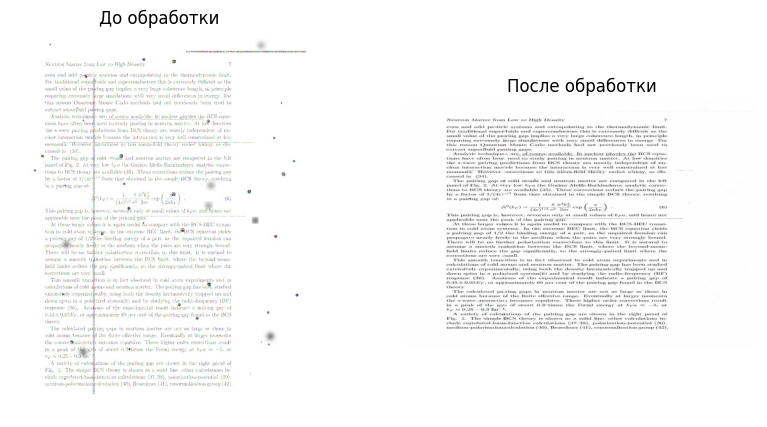

In [7]:
model_type = 'restormer'
distortion = 'bad_print'
print(f"\nТестирование модели {model_type} на искажении {distortion}")
model, needs_gray = load_model(model_type)

distortion_results_dir = os.path.join(results_dir, distortion)
os.makedirs(distortion_results_dir, exist_ok=True)

img_file = 'Restormer_1.jpg' # Указать название файла
img_path = os.path.join('/home/kudriavtcevroman-10/Tests', img_file) # Указать директорию, в которой находится файл

original_text = apply_ocr(img_path)
with open(os.path.join(distortion_results_dir, f"{img_file}_original.txt"), "w", encoding="utf-8") as f:
    f.write(original_text)

original_img = Image.open(img_path)
original_img.save(os.path.join(distortion_results_dir, f"{img_file}_original.png"))

processed_img = process_image(model, img_path, needs_gray)
processed_img_path = os.path.join(distortion_results_dir, f"{img_file}_processed.png")
processed_img.save(processed_img_path)

processed_text = apply_ocr(processed_img_path)
with open(os.path.join(distortion_results_dir, f"{img_file}_processed.txt"), "w", encoding="utf-8") as f:
    f.write(processed_text)

with open(os.path.join(distortion_results_dir, f"{img_file}_comparison.txt"), "w", encoding="utf-8") as f:
    f.write("Исходный OCR:\n")
    f.write(original_text)
    f.write("\n\nОбработанный OCR:\n")
    f.write(processed_text)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_img)
axes[0].set_title('До обработки')
axes[0].axis('off')
axes[1].imshow(processed_img)
axes[1].set_title('После обработки')
axes[1].axis('off')
plt.savefig(os.path.join(distortion_results_dir, f"{img_file}_comparison.png"))
plt.show()
plt.close()

## Шаг 8: Тестирование EnlightenGAN на brightness_contrast
Тестируем модель на изображении с искажением brightness_contrast, сохраняем результаты и сравнения.


Тестирование модели enlightengan на искажении brightness_contrast
/home/kudriavtcevroman-10/EnlightenGAN
/home/kudriavtcevroman-10
EnlightenGAN загружен


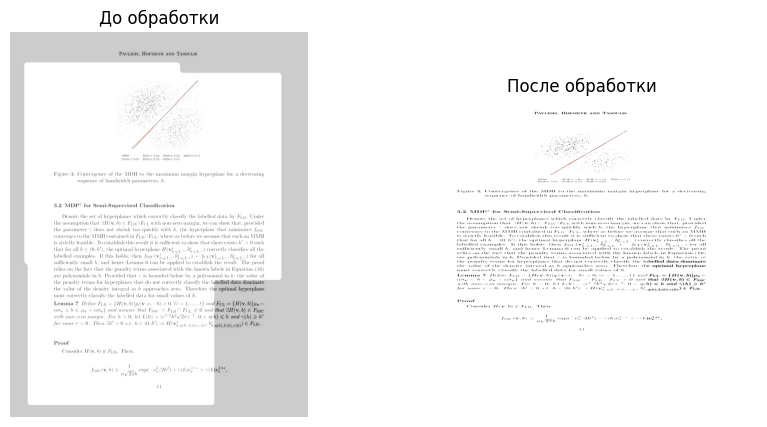

In [8]:
model_type = 'enlightengan'
distortion = 'brightness_contrast'
print(f"\nТестирование модели {model_type} на искажении {distortion}")
model, needs_gray = load_model(model_type)

distortion_results_dir = os.path.join(results_dir, distortion)
os.makedirs(distortion_results_dir, exist_ok=True)

img_file = 'Enlightengan_1.jpg'  # Указать название файла
img_path = os.path.join('/home/kudriavtcevroman-10/Tests', img_file) # Указать директорию, в которой находится файл

original_text = apply_ocr(img_path)
with open(os.path.join(distortion_results_dir, f"{img_file}_original.txt"), "w", encoding="utf-8") as f:
    f.write(original_text)

original_img = Image.open(img_path)
original_img.save(os.path.join(distortion_results_dir, f"{img_file}_original.png"))

processed_img = process_image(model, img_path, needs_gray)
processed_img_path = os.path.join(distortion_results_dir, f"{img_file}_processed.png")
processed_img.save(processed_img_path)

processed_text = apply_ocr(processed_img_path)
with open(os.path.join(distortion_results_dir, f"{img_file}_processed.txt"), "w", encoding="utf-8") as f:
    f.write(processed_text)

with open(os.path.join(distortion_results_dir, f"{img_file}_comparison.txt"), "w", encoding="utf-8") as f:
    f.write("Исходный OCR:\n")
    f.write(original_text)
    f.write("\n\nОбработанный OCR:\n")
    f.write(processed_text)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_img)
axes[0].set_title('До обработки')
axes[0].axis('off')
axes[1].imshow(processed_img)
axes[1].set_title('После обработки')
axes[1].axis('off')
plt.savefig(os.path.join(distortion_results_dir, f"{img_file}_comparison.png"))
plt.show()
plt.close()

## Шаг 9: Тестирование Real-ESRGAN на pixelation
Тестируем модель на изображении с искажением pixelation, сохраняем результаты и сравнения.


Тестирование модели real_esrgan на искажении pixelation
/home/kudriavtcevroman-10/Real-ESRGAN
/home/kudriavtcevroman-10
Real-ESRGAN загружен


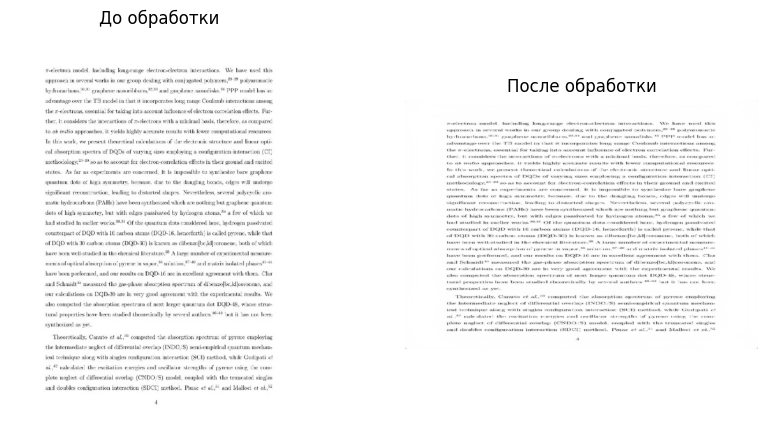

In [9]:
model_type = 'real_esrgan'
distortion = 'pixelation'
print(f"\nТестирование модели {model_type} на искажении {distortion}")
model, needs_gray = load_model(model_type)

distortion_results_dir = os.path.join(results_dir, distortion)
os.makedirs(distortion_results_dir, exist_ok=True)

img_file = 'Real-esrgan_3.jpg' # Указать название файла
img_path = os.path.join('/home/kudriavtcevroman-10/Tests', img_file)  # Указать директорию, в которой находится файл

original_text = apply_ocr(img_path)
with open(os.path.join(distortion_results_dir, f"{img_file}_original.txt"), "w", encoding="utf-8") as f:
    f.write(original_text)

original_img = Image.open(img_path)
original_img.save(os.path.join(distortion_results_dir, f"{img_file}_original.png"))

processed_img = process_image(model, img_path, needs_gray)
processed_img_path = os.path.join(distortion_results_dir, f"{img_file}_processed.png")
processed_img.save(processed_img_path)

processed_text = apply_ocr(processed_img_path)
with open(os.path.join(distortion_results_dir, f"{img_file}_processed.txt"), "w", encoding="utf-8") as f:
    f.write(processed_text)

with open(os.path.join(distortion_results_dir, f"{img_file}_comparison.txt"), "w", encoding="utf-8") as f:
    f.write("Исходный OCR:\n")
    f.write(original_text)
    f.write("\n\nОбработанный OCR:\n")
    f.write(processed_text)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_img)
axes[0].set_title('До обработки')
axes[0].axis('off')
axes[1].imshow(processed_img)
axes[1].set_title('После обработки')
axes[1].axis('off')
plt.savefig(os.path.join(distortion_results_dir, f"{img_file}_comparison.png"))
plt.show()
plt.close()